### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [3]:
import gurobipy as gp
from gurobipy import GRB
pth = ''
import sys
import math 
import time

from python.packages import *
from python.svm_mvo import *
from python.analysis_tools import *
from itertools import product
import os

%matplotlib inline
## Import Forecasts
forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-09


In [4]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [5]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))
#preprocessing
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
sigma_ = cov.mean()
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
cols =  ['Vol','INV1']
Y = wrds_tics.loc[:,cols] # Y matrix in formulation

def padm_data_treatment(Y):
    # Y['Momentum'] = wrds_tics.Momentum
    temp = -1*Y.Vol/Y.Vol.std(axis=0)
    #restrict the wharton research data to the columns of interest
    up_quantiles = Y.quantile(0.99)
    outliers_up = (Y > up_quantiles)
    Y = Y.mask(outliers_up, up_quantiles, axis=1) 
    Y.INV1 = (Y.INV1 - Y.INV1.median())/(Y.INV1.max() - Y.INV1.min()) #scale the features
    Y['Vol'] = temp
    Y.Vol = (Y.Vol - Y.Vol.max())/(Y.Vol.max() - Y.Vol.min())
    return Y

Y = padm_data_treatment(Y)
y_bar = ((Y**2).sum(axis=1).mean())

ret_constr = 0.05 #no return constraint
print("Feasibility Penalty ", sigma_/(sigma_*y_bar)**0.5)
soft_margin = 10 #10*sigma_/(sigma_*y_bar)**0.5 #large preference for separation feasibility

name = "no_neg"
ratio = 0.9 #% of assets
card_desc = "Card09"

turnover_descs = ["1"] #["0_75", "1", "1_25"]
turnovers = [1.00/6] #[0.75/6, 1.00/6, 1.25/6] #divide by 6!
AssetLim = math.floor(N*ratio)
epsilon = 1e-3 #epsilon hyper-parameter
non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
ratios = [0.9]#[0.1, 0.3, 0.5, 0.7, 0.9]
            #SVM Heavy to not heavy
epsilons = [1e-3]#[1e-4, 1e-5] # is no SVM consideration
epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3", 1e-4:"eps negative 4", 1e-5:"eps negative 5"}
card_desc_list = {0.1:"Card01", 0.3:"Card03", 0.5:"Card05", 0.7:"Card07", 0.9:"Card09"}
dpi_setting = 150

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

10

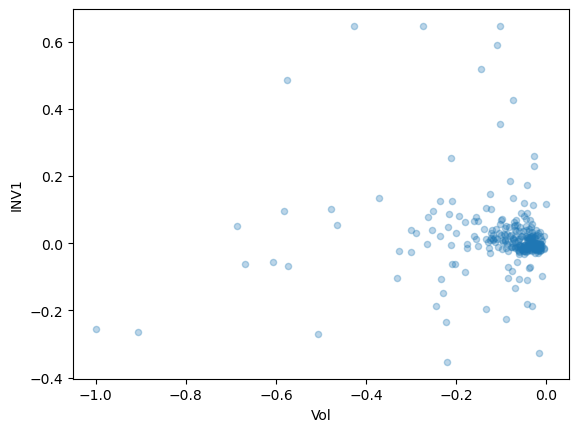

In [6]:
Y.plot.scatter(x = 'Vol', y = 'INV1', alpha = 0.3)
soft_margin

In [7]:
MVO_ = MVO(tics, mean, cov, ret_constr, Y, AssetLim, epsilon=epsilon)
SVM_ = SVM(tics, Y , soft_margin*np.ones_like(mean), non_neg = non_negativity_setting, epsilon=epsilon)
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 3, ParamLim = 5)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05
SVM_MVO_Fast.MVO_.model.params.timelimit = 10
SVM_MVO_Fast.SVM_.model.params.timelimit = 60
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
start = time.time()
SVM_MVO_Fast.silence_output()
SVM_MVO_Fast.initialize_soln()
print("Initialization successful")
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo, penalty_hist = SVM_MVO_Fast.solve_adm()
end = time.time()
print("Solution time", end - start)

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 60
Initialization successful
Solution time 109.73864459991455


In [8]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False, cardinality = True) #define an instance of the class
MVO2.set_model() #set up the model
MVO2.optimize() #find optimal solution
MVO2.model.params.outputflag = 0

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 290 rows, 858 columns and 1716 nonzeros
Model fingerprint: 0x366d32b3
Model has 41041 quadratic objective terms
Model has 286 general constraints
Variable types: 572 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 3e+02]
  GenCon rhs range [1e-05, 1e-05]
  GenCon coe range [1e+00, 1e+00]
Presolve added 285 rows and 0 columns
Presolve removed 0 rows and 286 columns
Presolve time: 0.02s
Presolved: 575 rows, 572 columns, 2002 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Found heuristic solution: objective 0.0738640
Found heuristic solution: objective 0.0563246

Root relaxation: objective 9.2602

In [9]:
print(SVM_MVO_Fast.b.x)
print(SVM_MVO_Fast.w.x)
ws = np.array([SVM_MVO_Fast.w.x[0], SVM_MVO_Fast.w.x[1], SVM_MVO_Fast.b.x[0]])
ws

[5.06107232e-13]
[0.02537388 0.00016349]


array([2.53738835e-02, 1.63490003e-04, 5.06107232e-13])

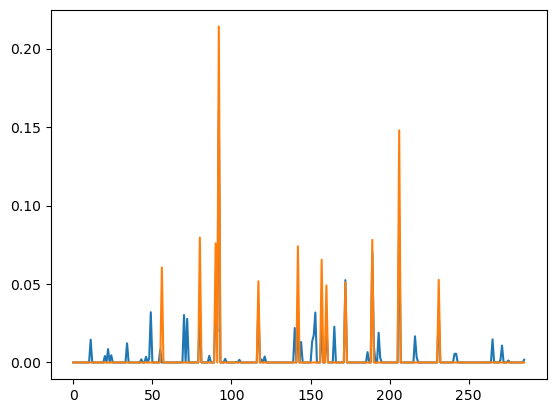

In [10]:
plt.plot(MVO2.x.x)
plt.plot(SVM_MVO_Fast.x.x)

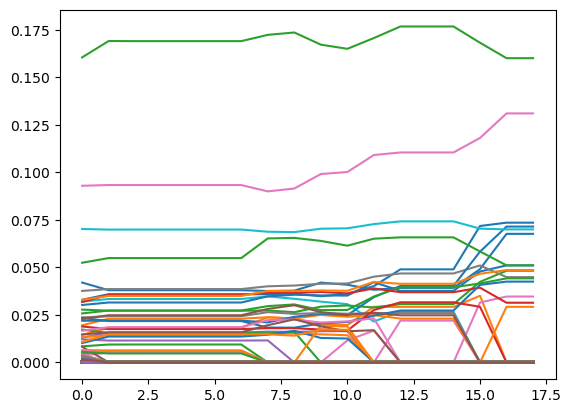

In [9]:
plt.plot(xs);
#plt.legend(cols)

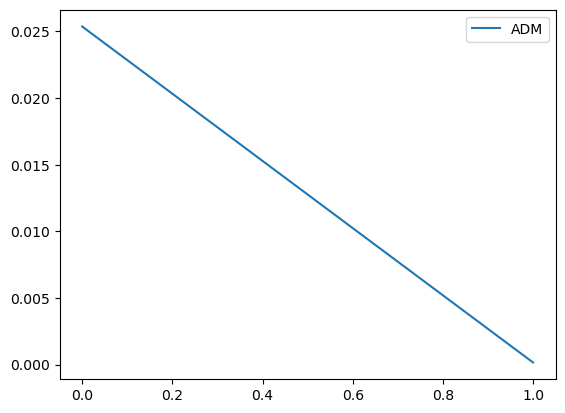

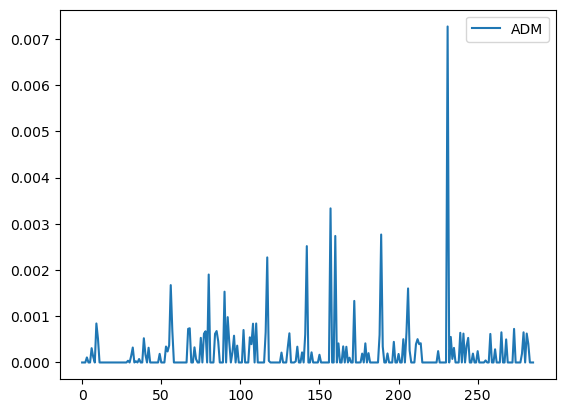

In [13]:
# plt.plot(SVM_MVO_Slck.w.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.w.x, label= 'ADM')
plt.legend();

plt.figure()
#plt.plot(SVM_MVO_Slck.xi.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.xi_mvo.x, label= 'ADM')
plt.legend();

In [14]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = 120 #len(rets.index)

In [15]:
"".join(map(str, cols))

'VolINV1'

In [16]:
for ratio, epsilon in product(ratios, epsilons):
    AssetLim = math.floor(N*ratio)

    SVM_MVO_Fast.MVO_.AssetLim = AssetLim
    SVM_MVO_Fast.MVO_.epsilon = epsilon
    SVM_MVO_Fast.SVM_.epsilon = epsilon
    card_desc = card_desc_list[ratio]
    print("processing asset limit ", AssetLim)

    isExist = os.path.exists("cache/Local Experiments/"+epsilons_desc[epsilon])
    if not isExist:
        os.makedirs("cache/Local Experiments/"+epsilons_desc[epsilon])
        print("The new directory is created!")
    for i in range(len(turnovers)):
        turnover = turnovers[i]
        turnover_desc = turnover_descs[i]
        adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols,
                 turnover, lr=0.0, data_treatment=padm_data_treatment)
        col_string = "".join(map(str, cols))
        out_pth = "cache/Local Experiments/"+epsilons_desc[epsilon] + "/" + "padm" +card_desc + "_" +col_string + "_" +turnover_desc + name + ".pkl"
        with open(out_pth, 'wb') as fp:
            pkl.dump(adm_results, fp)
#end here for now - 1:32 AM 2022 - 10 22

processing asset limit  257
Begin Relaxation
ADM terminated with C =  0.3125
_________________________
Iteration  0
Percent Complete  0.0
[4.13175804e-08 2.53259768e-05]
_________________________
Iteration  12
Percent Complete  0.1
[6.19585304e-12 5.63565421e-16]
_________________________
Iteration  24
Percent Complete  0.2
[6.34664679e-11 7.73882077e-16]
ADM terminated with C =  0.9867378715034965
ADM terminated with C =  1.7584783380681819
ADM terminated with C =  0.9867378715034965
_________________________
Iteration  36
Percent Complete  0.3
[3.23346036e-08 1.80838113e-15]
ADM terminated with C =  1.7584783380681819
ADM terminated with C =  0.9867378715034965
ADM terminated with C =  0.9867378715034965
ADM terminated with C =  0.9867378715034965
ADM terminated with C =  0.9867378715034965
ADM terminated with C =  0.9867378715034965
ADM terminated with C =  0.9867378715034965
ADM terminated with C =  0.9867378715034965
ADM terminated with C =  0.9867378715034965
ADM terminated with 

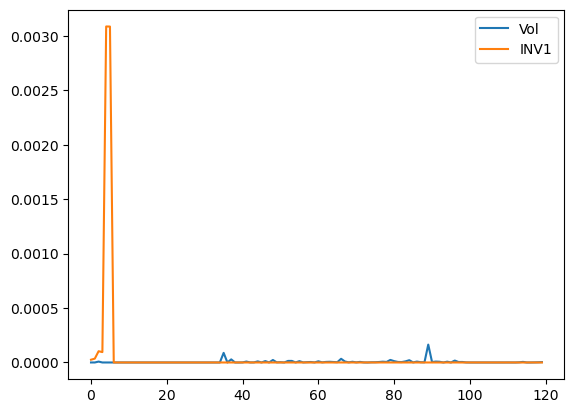

In [18]:
plt.plot(adm_results[3])
plt.legend(cols)

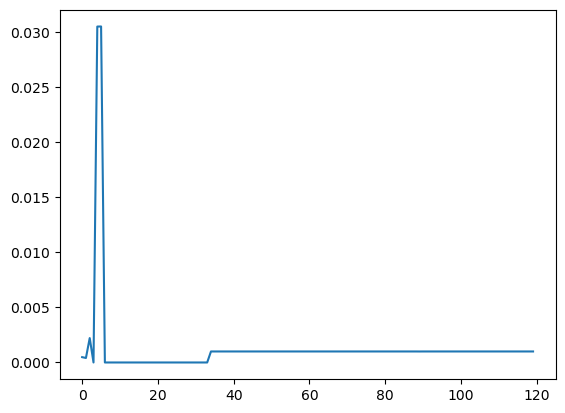

In [19]:
plt.plot(adm_results[4])
#plt.legend(cols)